In [1]:
import math
import matplotlib
import matplotlib.dates as dt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts

In [10]:
'''
EG两步检验
'''
def cointegration_test2(y, x):
    # 线性回归并取残差
    ols_result = sm.OLS(y,sm.add_constant(x)).fit()
    residual = ols_result.resid
    # ADF进行单位根检验   
    return ts.adfuller(residual)

'''
获取两个序列回归后的残差
'''
def get_residual(y, x):
    ols_result = sm.OLS(y,sm.add_constant(x)).fit()
    residual= ols_result.resid
    return(residual)

def get_params(y, x):
    ols_result = sm.OLS(y,sm.add_constant(x)).fit()
    return ols_result.params
'''
计算偏离均值程度
'''
def zscore(series):
    return (series - series.mean()) / np.std(series)

In [11]:
class Backtest:
    """
    Des: Backtest using historal data and transcation view
    
    Input:
        NA is not allowed
        Monthly frequence
        date(increasing): %Y/%m/%d
        history data: time series of history price of the assets
        transcation view: view of long, short or close a position
        risk-free rate: time series of risk-free rate
        freq: M, Q, D, Y
        initial_asset(=100): the value of initital asset
    """
    

    def __init__(self, df_date, df_history, df_view, df_rf,freq,initial_asset=100):
        self.df_date = df_date
        self.initial_asset = initial_asset
        self.df_rf = df_rf
        self.df_history = df_history
        self.df_view = df_view
        self.freq = freq
        if(self.freq == 'Y') :
            self.times = 1
        if(self.freq == 'Q') :
            self.times = 4
        if(self.freq == 'M') :
            self.times = 12
        if(self.freq == 'D') :
            self.times = 252

        ###  Calculate for Net Value of Asset with the transcation views  ###
        
        df_r = np.log(self.df_history/self.df_history.shift(1))
        # price obtained by simply view times history price
        ay_view = np.array(df_view)
        ay_history = np.array(df_history)
        ay_r = np.array(df_r)
        df_r = pd.DataFrame(ay_view*ay_r)
        
        # return of each asset
        self.df_r_all = df_r
        
        df_r = df_r.sum(axis = 1)
        df_r[0] = 0
        df_r = df_r + 1

        # the true value of assets each month
        df_asset = df_r.cumprod()*100

        # time series of net value with initital asset = initial_asset
        self.df_asset = df_asset
        self.df_r = df_r

    # Maximum retracement of the portfolio
    def maxdown(self):
        df_asset = self.df_asset
        md = ((df_asset.cummax()-df_asset)/df_asset).max()
        return md
    
    # Annualized return of the portfolio
    def annualized_return(self):
        Times = self.times
        df_asset = self.df_asset
        start = 0;
        lst_annualized_return = []
        while(True):
            try:
                df_asset[start+Times]
            except:
                break
            if(len(df_asset[start:start+Times+1])<Times):
                break
            Log_return = (df_asset[start+Times-1] - df_asset[start])/df_asset[start]
            lst_annualized_return.append(Log_return)
            start = start + Times
        return (np.array(lst_annualized_return))
    
    # Annualized volatility of the portfolio
    def annualized_volatility(self):
        YV = np.std(self.annualized_return()) * np.sqrt(self.times)
        return YV
    
    # Sharpe ratio of the portfolio
    def sharpe(self):
        ER = self.annualized_return().mean()
        RF = self.df_rf.mean()[0]
        YV = self.annualized_volatility()
        return (ER - RF) / YV
    
    # Net value of the portfolio
    def net_value(self):
        return self.df_asset
        
    def print_info(self):
        """
        Des: Print the info of the backtest results

        """
        printf("The maxdown is %.4f"%(self.maxdown())+"\n")
        printf("The annualized return is %.4f"%(self.annualized_return())+"\n")
        printf("The annualized volatility is %.4f"%(self.annualized_volatility().mean())+"\n")
        printf("The annualized sharpe ratio is %.4f"%(self.sharpe())+"\n")

    def get_info(self):
        SP = self.sharpe()
        YR = self.annualized_return().mean()
        YV = self.annualized_volatility()
        MD = self.maxdown()
        info = pd.DataFrame({"Sharpe":SP,"Annualized Return":YR,"Annualized Volatility":YV,
                            "Maximum Drawdown":MD},index=["Value"])
        return info
        
    def gen_graph(self):
        """
        Des: gen the graph of backtest (using R)
        """
        
        
    def save_graph(self, path):
        """
        Des: Save the graph of backtest
        Input: 
            path: the path for saving graph
        """

In [12]:
def Plot2(date,data1,data2,title="",label1="",label2="",\
         save_path=False,figure_size=[18,4]):

    year = dt.YearLocator()
    yearformat = dt.DateFormatter('%Y')
    fig=plt.figure(figsize=figure_size)
    ax = fig.add_subplot(1, 1, 1)
    ax.plot_date(pd.to_datetime(date),data1,'-',\
                 linewidth = 2.5,label=label1, alpha=1)
    ax.plot_date(pd.to_datetime(date),data2,'-',\
                 linewidth = 2.5,label=label2, alpha=1)
    ax.xaxis.set_major_locator(year)
    #ax.yaxis.set_major_formatter(FuncFormatter(to_percent))
    ax.xaxis.set_major_formatter(yearformat)
    ax.legend(fontsize=14)
    ax.set_title(title,fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    if save_path:
        fig.savefig(save_path) 

In [13]:
# 获取2019-01-01-2020-12-31期间2年期、5年期、10年期国债期货主力连结历史数据
df2 = get_price('T9999.CCFX', start_date='2019-01-01', end_date='2021-03-31')
df5 = get_price('TF9999.CCFX', start_date='2019-01-01', end_date='2021-03-31')
df10 = get_price('TS9999.CCFX', start_date='2019-01-01', end_date='2021-03-31')

# 输出备用
df2.to_csv("2年期国债期货价格日度数据.csv")
df5.to_csv("5年期国债期货价格日度数据.csv")
df10.to_csv("10年期国债期货价格日度数据.csv")

# 一阶差分
n=1
df2_diff = df2.diff(periods=n).dropna()
df5_diff = df5.diff(periods=n).dropna()
df10_diff = df10.diff(periods=n).dropna()

In [16]:
# 训练集中开盘价的时间序列
ay_close2 = np.array(df2['close'])
ay_close5 = np.array(df5['close'])
ay_close10 = np.array(df10['close'])

# 训练集中一阶差分时间序列
ay_close2_diff = np.array(df2_diff['close'])
ay_close5_diff = np.array(df5_diff['close'])
ay_close10_diff = np.array(df10_diff['close'])

In [17]:
ols_result = sm.OLS(ay_close2_diff ,sm.add_constant(ay_close5_diff)).fit()
ols_result.resid

array([0.05740801214539561, -0.14784841403261034, -0.027015060001184005,
       0.33788882675274534, -0.12374584356139685, -0.14310484021062259,
       0.0032734039255099927, -0.11342534188601369, -0.03288045178130066,
       0.2967029332972632, 0.0017990465433036784, -0.1537138058127128,
       -0.06255995010590955, 0.040036225234419964, -0.15076509104832359,
       0.029170833454307852, -0.10755995010589704, -0.0011496682210855452,
       0.16913879570561824, 0.08885033177892707, -0.02054070261899645,
       -0.05932277141481326, 0.23497214973703776, -0.05730352392789221,
       -0.046983022252494844, -0.1304766271216205, 0.045645190836500524,
       -0.07547662712161367, 0.17708751047001708, 0.05179904654332425,
       -0.23781637628392358, -0.09342534188601767, -0.15983562377084132,
       -0.13839330413731998, 0.13561315308781874, -0.11550866487031933,
       -0.10989969926821035, 0.21471572355903407, 0.06122211868991523,
       0.11740801214539788, 0.31936318413495557, -0.0373355

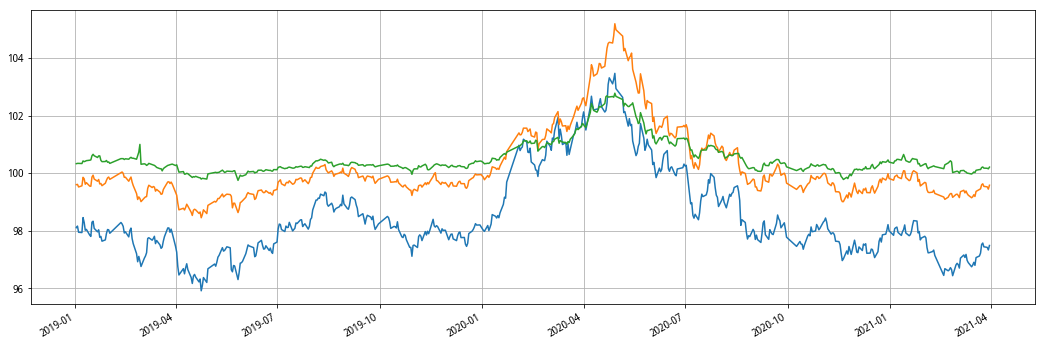

In [5]:
df2['close'].plot(figsize = (18,6),grid = True)
df5['close'].plot(figsize = (18,6),grid = True)
df10['close'].plot(figsize = (18,6),grid = True)

In [6]:
# 对原序列和一阶差分序列进行ADF检验，p值>0.05则不平稳
print(ts.adfuller(ay_close2)[1],ts.adfuller(ay_close5)[1],ts.adfuller(ay_close10)[1])
print(ts.adfuller(ay_close2_diff)[1],ts.adfuller(ay_close5_diff)[1],ts.adfuller(ay_close10_diff)[1])

0.3573169084207331 0.5151516033786998 0.4346967784982354
2.3046443859347312e-24 3.632471147065853e-30 2.5172505921091663e-30


一阶差分序列均为平稳序列，即一阶单整，可以进行协整检验

In [7]:
# 窗宽width
# 残差阈值ratio
width = 60
start = 0
ratio = 1.1

In [8]:
df_view = pd.DataFrame(columns=['2年期','5年期','10年期'],index = df2.index)
df_view.fillna(0,inplace=True)

while(start + 2 * width<len(df2)):
    ay_close2 = np.array(df2.iloc[start:start+width]['close'])
    ay_close5 = np.array(df5[start:start+width]['close'])
    ay_close10 = np.array(df10[start:start+width]['close'])
    ay_close_next2 = np.array(df2.iloc[start+width:start+2*width]['close'])
    ay_close_next5 = np.array(df5.iloc[start+width:start+2*width]['close'])
    ay_close_next10 = np.array(df10.iloc[start+width:start+2*width]['close'])
    ay_close_all2 = np.array(df2.iloc[start:start+2*width]['close'])
    ay_close_all5 = np.array(df5.iloc[start:start+2*width]['close'])
    ay_close_all10 = np.array(df10.iloc[start:start+2*width]['close'])
    p_2_5 = cointegration_test2(ay_close_all2,ay_close_all5)[1]
    p_2_10 = cointegration_test2(ay_close_all2,ay_close_all10)[1]
    p_5_10 = cointegration_test2(ay_close_all5,ay_close_all10)[1]
    if(p_2_5<0.1):
        a,b = get_params(ay_close_all2,ay_close_all5)
        mean_residual_2_5 = mean(ay_close_all2-a-b*ay_close_all5)
        residual_next_2_5 = (ay_close_next2-a-b*ay_close_next5)[0]
        '''
        mean_residual_2_5 = mean(get_residual(ay_close2,ay_close5))
        mean_residual_next_2_5 = mean(get_residual(ay_close_next2,ay_close_next5))
        '''
        if(residual_next_2_5 > mean_residual_2_5*ratio):
            df_view.iloc[start+width:start+2*width]['2年期']-=1
            df_view.iloc[start+width:start+2*width]['5年期']+=1
        if(residual_next_2_5 < mean_residual_2_5/ratio):
            df_view.iloc[start+width:start+2*width]['2年期']+=1
            df_view.iloc[start+width:start+2*width]['5年期']-=1
        
        #ols_result = sm.OLS(ay_close2,sm.add_constant(ay_close5)).fit()
        #a1,b1 = ols_result.params
        #flag1 = 1
    if(p_2_10<0.1):
        a,b = get_params(ay_close_all2,ay_close_all10)
        mean_residual_2_10 = mean(ay_close_all2-a-b*ay_close_all10)
        residual_next_2_10 = (ay_close_next2-a-b*ay_close_next10)[0]
        '''
        mean_residual_2_10 = mean(get_residual(ay_close2,ay_close10))
        mean_residual_next_2_10 = mean(get_residual(ay_close_next2,ay_close_next10))
        '''
        if(residual_next_2_10 > mean_residual_2_10*ratio):
            df_view.iloc[start+width:start+2*width]['2年期']-=1
            df_view.iloc[start+width:start+2*width]['10年期']+=1
        if(residual_next_2_10 < mean_residual_2_10/ratio):
            df_view.iloc[start+width:start+2*width]['2年期']+=1
            df_view.iloc[start+width:start+2*width]['10年期']-=1
        #ols_result = sm.OLS(ay_close2,sm.add_constant(ay_close10)).fit()
        #a2,b2 = ols_result.params
        #flag2 = 1
    if(p_5_10<0.1):
        a,b = get_params(ay_close_all5,ay_close_all10)
        mean_residual_5_10 = mean(ay_close_all5-a-b*ay_close_all10)
        residual_next_5_10 = (ay_close_next5-a-b*ay_close_next10)[0]
        
        '''
        mean_residual_5_10 = mean(get_residual(ay_close5,ay_close10))
        mean_residual_next_5_10 = mean(get_residual(ay_close_next5,ay_close_next10))
        '''
        if(residual_next_5_10 > mean_residual_5_10*ratio):
            df_view.iloc[start+width:start+2*width]['5年期']-=1
            df_view.iloc[start+width:start+2*width]['10年期']+=1
        if(residual_next_5_10 < mean_residual_5_10/ratio):
            df_view.iloc[start+width:start+2*width]['5年期']+=1
            df_view.iloc[start+width:start+2*width]['10年期']-=1
        #ols_result = sm.OLS(ay_close5,sm.add_constant(ay_close10)).fit()
        #a3,b3 = ols_result.params
        #flag3 = 1
    start = start + width

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

In [9]:
df_view.to_csv('view.csv')

In [10]:
df_history = pd.concat([df2['close'],df5['close'],df10['close']],axis=1)
df_history.columns = ['2年期','5年期','10年期']
df_rf = pd.DataFrame(np.repeat(0,545))

In [11]:
df_view_base = pd.DataFrame(columns=['2年期','5年期','10年期'],index = df2.index).fillna(1/3)

In [15]:
BT = Backtest(df_view.index, df_history, df_view, df_rf,'D',initial_asset=100)
BTM = Backtest(df_view_base.index, df_history, df_view_base, df_rf,'D',initial_asset=100)

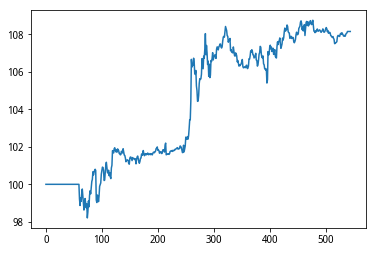

In [16]:
plt.plot(BT.df_asset)

In [17]:
display(BT.get_info(),BTM.get_info())

,Sharpe,Annualized Return,Annualized Volatility,Maximum Drawdown
Value,0.159784,0.040165,0.251372,0.028637


,Sharpe,Annualized Return,Annualized Volatility,Maximum Drawdown
Value,-0.002785,-0.00017,0.061037,0.053947


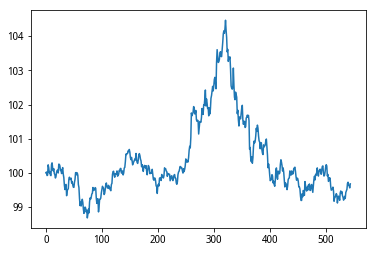

In [18]:
plt.plot(BTM.df_asset)

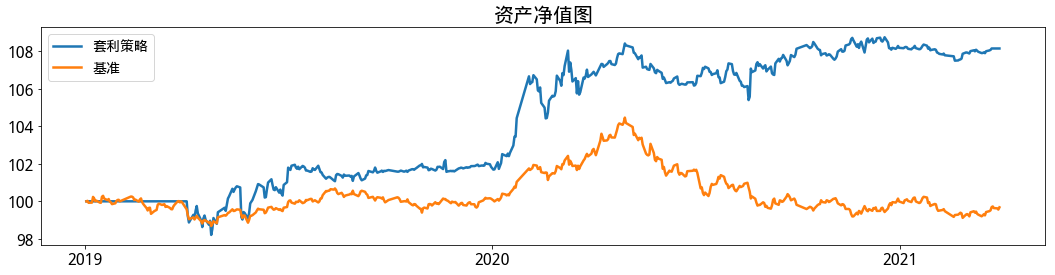

In [19]:
Plot2(df_view.index,BT.df_asset,BTM.df_asset,title="资产净值图",label1="套利策略",label2="基准")

2年期和5年期协整，2年期和10年期、5年期和十年期不协整

In [9]:
ols_result = sm.OLS(ay_close5,ay_close2,ay_close10).fit()
residual = ols_result.resid
# ADF进行单位根检验   
ts.adfuller(residual)

/opt/conda/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:651: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if (missing == 'drop' and 'missing_idx' in kwargs and
/opt/conda/lib/python3.6/site-packages/statsmodels/base/data.py:63: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if missing != 'none':


(-2.981495753422889,
 0.036658972665081585,
 0,
 436,
 {'1%': -3.445437655635993,
  '5%': -2.8681918844944785,
  '10%': -2.5703132171113543},
 -501.1012033187893)

In [61]:
print(ts.coint(ay_close2,ay_close5)[1],
      ts.coint(ay_close2,ay_close10)[1],
      ts.coint(ay_close5,ay_close10)[1])

0.23927552552558568 0.15926391071891477 0.00275910163411858


In [47]:
cointegration_test(ay_close5,ay_close10)

(-1.7145572992141584,
 0.42362815605552007,
 0,
 423,
 {'1%': -3.4459042013025836,
  '5%': -2.8683970525583358,
  '10%': -2.5704225783970176},
 -590.2044324449256)